<h3>Import Google colab to load the google drive</h3>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


<h3>Memory management</h3>

In [2]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.5 GB  | Proc size: 727.5 MB
GPU RAM Free: 11320MB | Used: 121MB | Util   1% | Total 11441MB


In [4]:
import gc
gc.collect()

0

<h3>Import required packages</h3>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

<h3>Declare fido test videos and training images file path</h3>

In [6]:
fido_images_path = '/content/gdrive/My Drive/Capstone/Characters/FidoDido/Images/'
fido_videos_path = '/content/gdrive/My Drive/Capstone/Characters/FidoDido/Videos/'
os.listdir(fido_videos_path)

['FidoDidoV1.webm',
 'FidoDidoV2.webm',
 'FidoDidoV3.webm',
 'FidoDidoV4.webm',
 'FidoDidoV5.webm',
 'FidoDidoV6.webm',
 'FidoDidoV7.webm',
 'FidoDidoV8.webm',
 'VidImg',
 'FidoDidoV9.webm']

<h3>Declare MickeyMouse test videos and training images file path</h3>

In [7]:
mm_images_path = '/content/gdrive/My Drive/Capstone/Characters/MickeyMouse/Images/'
mm_videos_path = '/content/gdrive/My Drive/Capstone/Characters/MickeyMouse/Videos/'
os.listdir(mm_videos_path)

['MMV1.mp4', 'MMV2.webm', 'VidImg']

<h3>Declare MrBean test videos and training images file path</h3>

In [8]:
mb_images_path = '/content/gdrive/My Drive/Capstone/Characters/MrBean/Images/'
mb_videos_path = '/content/gdrive/My Drive/Capstone/Characters/MrBean/Videos/'
os.listdir(mb_videos_path)

['BV1.webm', 'VidImg']

<h3>Declare FelixTheCat test videos and training images file path</h3>

In [9]:
fc_images_path = '/content/gdrive/My Drive/Capstone/Characters/Felix/Images/'
fc_videos_path = '/content/gdrive/My Drive/Capstone/Characters/Felix/Videos/'
os.listdir(fc_videos_path)

['y2mate.com - felix_the_cat_uncle_toms_crabbin_1920_1929_british_pathe_ZpjeGHUimIU_360p.mp4',
 'FC_V1.webm',
 'VidImg']

<h3>Custom function to create folder</h3>

In [0]:
import os

def createFolder(directory):# creates a folder in the location mentioned
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
    

In [0]:
# Example
# createFolder(fido_videos_path+'VidImg/')
# Creates a folder in the current directory called data

In [0]:
import cv2
import math

<h3>Test by viewing some of the test images each in mickey and fido</h3>

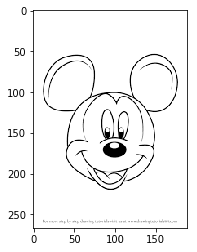

In [0]:
plt.imshow(cv2.imread(mm_images_path+'MM1.png'))

In [0]:
cv2.imread(mm_images_path+'MM1.png').shape

(267, 189, 3)

In [0]:
np.zeros((2,3)).reshape(6,1)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

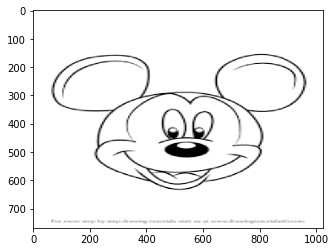

In [0]:
plt.imshow(cv2.resize(cv2.imread(mm_images_path+'MM1.png'),(1024,768)))

In [0]:
cv2.imread(mm_images_path+'MM1.png').shape

(267, 189, 3)

In [0]:
cv2.resize(cv2.imread(mm_images_path+'MM1.png'),(224,224)).shape # VGG's i/p shape is 224,224

(224, 224, 3)

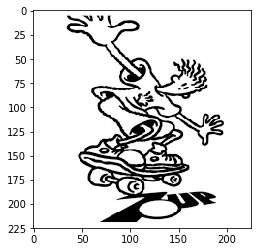

In [0]:
plt.imshow(cv2.imread(fido_images_path+'FidoDido1.png'))

In [0]:
cv2.imread(fido_images_path+'FidoDido1.png').shape # cv2 converts image to pixel value

(225, 225, 3)

In [0]:
cv2.resize(cv2.imread(fido_images_path+'FidoDido1.png'),(224,224)).shape

(224, 224, 3)

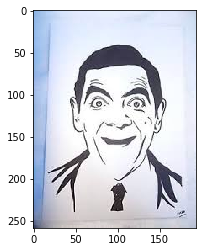

In [0]:
plt.imshow(cv2.imread(mb_images_path+'B1.jpg'))

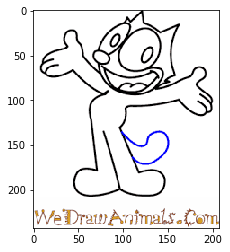

In [0]:
plt.imshow(cv2.imread(fc_images_path+'Felix_the_cat_img_1.png'))

Iterative Training

In [13]:
import keras
import tensorflow as tf
from keras.applications import vgg16

Using TensorFlow backend.


In [0]:
def computeAucRocCurve(Y_actual, Y_predicted):
  from sklearn.metrics import roc_curve, auc
  lw = 2
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(Y_actual.shape[1]):
      fpr[i], tpr[i], _ = roc_curve(Y_actual[:, i], Y_predicted[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(Y_actual.ravel(), Y_predicted.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  
  from scipy import interp
  from itertools import cycle
  
  n_classes = Y_actual.shape[1]
  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]),
           color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()


In [0]:
createFolder('/content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/')

-------------------------Start of loop #  0 ---------------------------
End of  fido  loop #  0
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  0
(400, 224, 224, 3)
(400,)
mm      200
fido    200
dtype: int64
End of  mb  loop #  0
(600, 224, 224, 3)
(600,)
mm      200
mb      200
fido    200
dtype: int64
End of  fc  loop #  0
(800, 224, 224, 3)
(800,)
mm      200
fc      200
fido    200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 6s 0us/step
Instructions for updating:
Please use `rate` instea

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 15s 30ms/step - loss: 7.9262 - acc: 0.4160 - val_loss: 8.4828 - val_acc: 0.4577

Epoch 00001: val_acc improved from -inf to 0.45771, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/vgg16/vgg16_best_weights.h5
Epoch 2/50
500/500 [==============================] - 9s 18ms/step - loss: 8.0339 - acc: 0.4900 - val_loss: 8.6715 - val_acc: 0.4378

Epoch 00002: val_acc did not improve from 0.45771
Epoch 3/50
500/500 [==============================] - 9s 18ms/step - loss: 7.9537 - acc: 0.5020 - val_loss: 8.5356 - val_acc: 0.4527

Epoch 00003: val_acc did not improve from 0.45771
Epoch 4/50
500/500 [==============================] - 9s 18ms/step - loss: 7.9461 - acc: 0.5020 - val_loss: 8.6351 - val_acc: 0.4478

Epoch 00004: val_acc did not improve from 0.45771
Epoch 5/50
500/500 [==============================] - 9s 18ms/step - loss: 7.9753 - acc: 0.4980 - val_loss: 8.

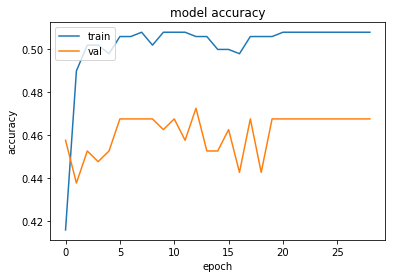

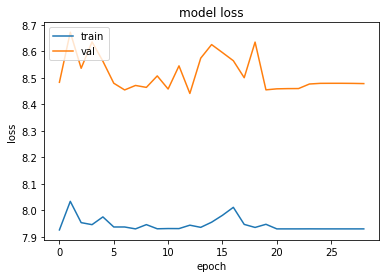

0.494949494949495
[[ 0  0  6 17]
 [ 0  0  9 17]
 [ 0  0 26  1]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        26
           2       0.63      0.96      0.76        27
           3       0.40      1.00      0.57        23

    accuracy                           0.49        99
   macro avg       0.26      0.49      0.33        99
weighted avg       0.27      0.49      0.34        99



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


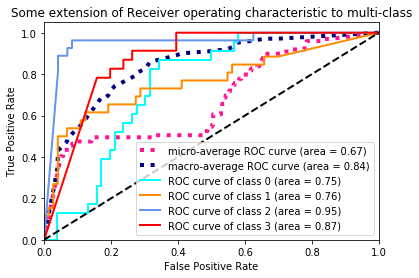

-------------------------End of loop #  0 ---------------------------
-------------------------Start of loop #  1 ---------------------------
End of  fido  loop #  1
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  1
(400, 224, 224, 3)
(400,)
mm      200
fido    200
dtype: int64
End of  mb  loop #  1
(600, 224, 224, 3)
(600,)
mm      200
mb      200
fido    200
dtype: int64
End of  fc  loop #  1
(800, 224, 224, 3)
(800,)
mm      200
fc      200
fido    200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape           

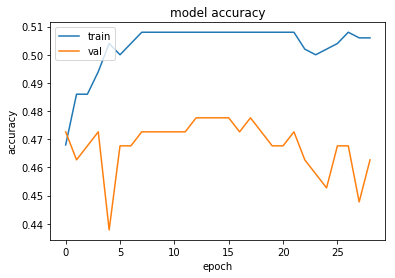

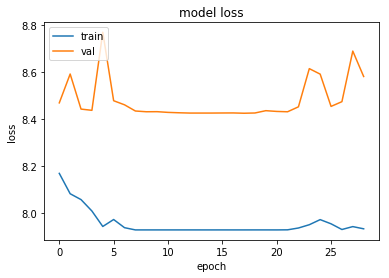

0.494949494949495
[[ 0  0  2 21]
 [ 0  0 13 13]
 [ 0  0 26  1]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        26
           2       0.63      0.96      0.76        27
           3       0.40      1.00      0.57        23

    accuracy                           0.49        99
   macro avg       0.26      0.49      0.33        99
weighted avg       0.27      0.49      0.34        99



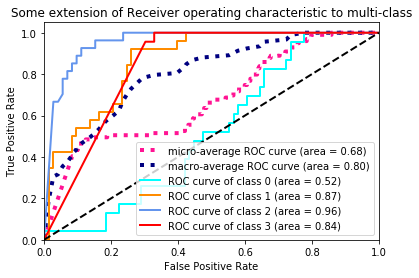

-------------------------End of loop #  1 ---------------------------
-------------------------Start of loop #  2 ---------------------------
End of  fido  loop #  2
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  2
(400, 224, 224, 3)
(400,)
mm      200
fido    200
dtype: int64
End of  mb  loop #  2
(600, 224, 224, 3)
(600,)
mm      200
mb      200
fido    200
dtype: int64
End of  fc  loop #  2
(800, 224, 224, 3)
(800,)
mm      200
fc      200
fido    200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape           

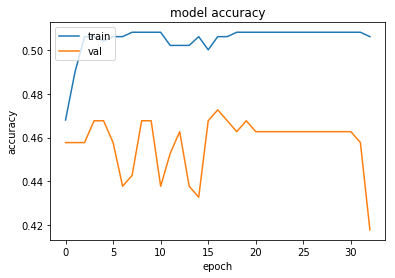

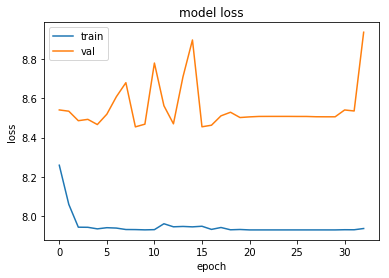

0.43434343434343436
[[ 0  0  0 23]
 [ 0  0  7 19]
 [ 0  0 20  7]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        26
           2       0.74      0.74      0.74        27
           3       0.32      1.00      0.48        23

    accuracy                           0.43        99
   macro avg       0.27      0.44      0.31        99
weighted avg       0.28      0.43      0.31        99



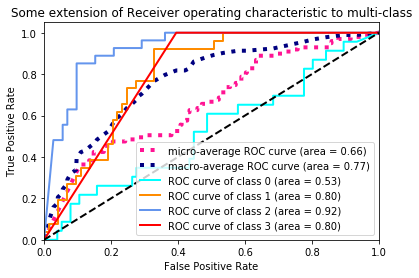

-------------------------End of loop #  2 ---------------------------
-------------------------Start of loop #  3 ---------------------------
End of  fido  loop #  3
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  3
(400, 224, 224, 3)
(400,)
mm      200
fido    200
dtype: int64
End of  mb  loop #  3
(600, 224, 224, 3)
(600,)
mm      200
mb      200
fido    200
dtype: int64
End of  fc  loop #  3
(800, 224, 224, 3)
(800,)
mm      200
fc      200
fido    200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape           

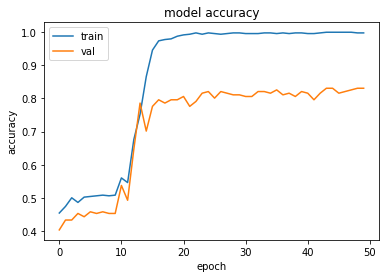

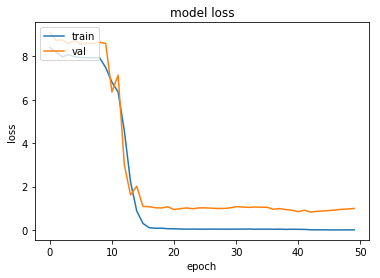

0.797979797979798
[[21  1  1  0]
 [ 2 21  3  0]
 [ 4  3 20  0]
 [ 6  0  0 17]]
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        23
           1       0.84      0.81      0.82        26
           2       0.83      0.74      0.78        27
           3       1.00      0.74      0.85        23

    accuracy                           0.80        99
   macro avg       0.83      0.80      0.80        99
weighted avg       0.83      0.80      0.80        99



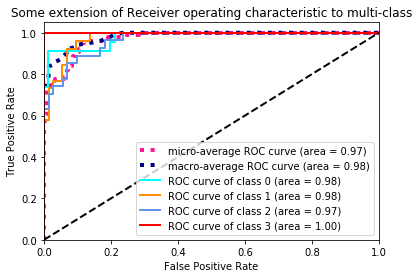

-------------------------End of loop #  3 ---------------------------
-------------------------Start of loop #  4 ---------------------------
End of  mb  loop #  4
(600, 224, 224, 3)
(600,)
mm      200
mb      200
fido    200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________

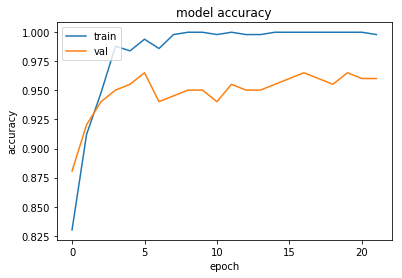

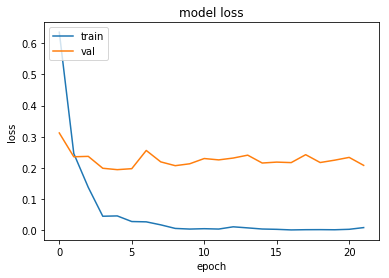

0.9090909090909091
[[21  0  1  1]
 [ 3 22  0  1]
 [ 1  1 24  1]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        23
           1       0.96      0.85      0.90        26
           2       0.96      0.89      0.92        27
           3       0.88      1.00      0.94        23

    accuracy                           0.91        99
   macro avg       0.91      0.91      0.91        99
weighted avg       0.91      0.91      0.91        99



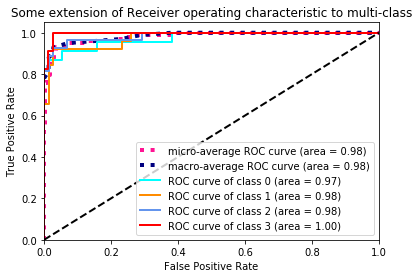

-------------------------End of loop #  4 ---------------------------


In [0]:
# Initialize variable with values
initialLoop = 0
totalLoop = 5
loadBatchSize = 200
modelSaveFolder = '/content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/vgg16/'
modelJsonFile = modelSaveFolder+'vgg16_model.json'
modelWeightsFile = modelSaveFolder+'vgg16_best_weights.h5'
input_shape = (224,224,3)
imgData = {'fido':fido_images_path,'mm':mm_images_path,'mb':mb_images_path,'fc':fc_images_path}

for loop in np.arange(initialLoop, totalLoop):## outer loop to train images
  print('-------------------------Start of loop # ',loop,'---------------------------')
  X=[]
  Y=[]
  highImgCount = (loop+1)*loadBatchSize
  lowImgCount = (loop)*loadBatchSize
  for imgName,imgPath in imgData.items(): ## inner loop to iterate over different classes
    count = 0
    for img in os.listdir(imgPath): ## inner loop to iterate over contents of a class directory
      if(count >= lowImgCount):
        if(count < highImgCount):
          #print(img)

          ## Create X and Y (independant and dependant variables)

          X.append(cv2.resize(cv2.imread(imgPath+img),(224,224))/255)
          Y.append(imgName)
             
        else:
          print('End of ',imgName,' loop # ',loop)
          print(np.array(X).shape)
          print(np.array(Y).shape)
          print(pd.Series(np.array(Y)).value_counts())
          break
      count = count + 1
  import copy
  Y_act = copy.deepcopy(Y)
  
  ## Converion of independant and dependant variables to numpy arrays
  
  X = np.array(X)
  Y = np.array(Y)
  Y_act = np.array(Y_act)
  
  ## Encode dependant variable (label) using LabelEncoder
  
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  Y = le.fit_transform(Y)
  pd.Series(Y).value_counts()
  Y_act = le.fit_transform(Y_act)
  pd.Series(Y_act).value_counts()
  
  ## One-hot encoding of dependant variable
  
  import keras
  Y = keras.utils.to_categorical(Y)
  
  ## Train, Validation and Test split
  
  from sklearn.model_selection import train_test_split
  X_train,X_valtest,Y_train,Y_valtest = train_test_split(X,Y,test_size=0.375,random_state=2019)
  X_val,X_test,Y_val,Y_test = train_test_split(X_valtest,Y_valtest,test_size=0.33,random_state=2019)
  
  print('X_test and Y_test split')
  print(X_train.shape)
  print(X_val.shape)
  print(X_test.shape)
  print(Y_train.shape)
  print(Y_val.shape)
  print(Y_test.shape)
  
  from sklearn.model_selection import train_test_split
  X_a_train,X_a_valtest,Y_a_train,Y_a_valtest = train_test_split(X,Y_act,test_size=0.375,random_state=2019)
  X_a_val,X_a_test,Y_a_val,Y_a_test = train_test_split(X_a_valtest,Y_a_valtest,test_size=0.33,random_state=2019)
  
  print('X_a_test and Y_a_test split')
  print(X_a_train.shape)
  print(X_a_val.shape)
  print(X_a_test.shape)
  print(Y_a_train.shape)
  print(Y_a_val.shape)
  print(Y_a_test.shape)
  
  ## Verify whether train, validation and test split is equal among classes
  
  print('Y_a_test classwise count')
  print(pd.Series(Y_a_train).value_counts())
  print(pd.Series(Y_a_val).value_counts())
  print(pd.Series(Y_a_test).value_counts())
  
  from keras import Sequential, Model
  from keras.layers import InputLayer, Dense, Dropout,Flatten
  
  if (loop == 0):
    #  ---------------Initialise and create model ------------------  #
    
    vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg.trainable = False
    for layer in vgg.layers:
      layer.trainable = False

    A = vgg.output
    A = Flatten()(A)
    B = Dense(512, activation='relu')(A)
    B = Dropout(0.3)(B)
    #B = Dense(512, activation='relu')(B)
    #B = Dropout(0.3)(B)
    predictions = Dense(4, activation='softmax')(B)
    
    vgg16_model = Model(input=vgg.input, output=predictions)
  
  else:
    
    #  ---------------Load model and weights from disk-------------  #
    from keras.models import model_from_json

    # load json from saved location 
    
    json_file = open(modelJsonFile, 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    # create model from json and load weights
    
    vgg16_model = model_from_json(loaded_model_json)
    
    vgg16_model.load_weights(modelWeightsFile)
  
  # Compile the model
  vgg16_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  print(vgg16_model.summary())
  
  # Print the trainable value for all layers
  for layer in vgg16_model.layers:
    print(layer.name,' -> ',layer.trainable)
  
  createFolder(modelSaveFolder)
  
  # Callback initialization
  from keras.callbacks import EarlyStopping,ModelCheckpoint
  es_vgg16 = EarlyStopping(monitor='val_acc',patience=16,verbose=1,mode='auto')
  mc_vgg16 = ModelCheckpoint(filepath=modelWeightsFile,monitor='val_acc',verbose=1,save_best_only=True,save_weights_only=True,mode='auto')

  vgg16_his = vgg16_model.fit(x=X_train,y=Y_train,validation_data=(X_val,Y_val), epochs=50,batch_size=20, callbacks=[es_vgg16,mc_vgg16])

  plt.plot(vgg16_his.history['acc'],label='train')
  plt.plot(vgg16_his.history['val_acc'],label='val')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(vgg16_his.history['loss'],label='train')
  plt.plot(vgg16_his.history['val_loss'],label='val')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  
  # -----------------Write model to disk----------------------
  # serialize model to JSON
  
  with open(modelJsonFile, "w") as json_file:
      json_file.write(vgg16_model.to_json())

  
  # Predictions using vgg16 model
  
  Y_test_proba_pred = vgg16_model.predict(X_test)
  
  # Convert prediction probabilities to predict_classes for Y_test and Y_pred

  yPredLst = []
  for yPred in Y_test_proba_pred:
    yPredLst.append(np.argmax(yPred))

  yPredTest = np.array(yPredLst)

  yTestLst = []
  for yTest in Y_test:
    yTestLst.append(np.argmax(yTest))

  yTest = np.array(yTestLst)
  
  # Evaluation metrics for the model
  
  from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
  print(accuracy_score(yTest, yPredTest))
  print(confusion_matrix(yTest, yPredTest))
  print(classification_report(yTest, yPredTest))
  computeAucRocCurve(Y_test, Y_test_proba_pred)
  
  # Deleting unused variables
  del X,Y,Y_act,yPredLst,yPredTest,yTestLst,yTest,Y_test_proba_pred,vgg16_his,mc_vgg16,es_vgg16,vgg16_model,X_train,X_valtest,Y_train,Y_valtest,X_a_train,X_a_valtest,Y_a_train,Y_a_valtest,X_val,X_test,Y_val,Y_test,X_a_val,X_a_test,Y_a_val,Y_a_test
  gc.collect()
  print('-------------------------End of loop # ',loop,'---------------------------')


In [19]:
from keras.applications import inception_v3
mdl = inception_v3.InceptionV3(weights='imagenet', input_shape=input_shape)

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 30s 0us/step


In [0]:
def trainModelWithNeuralNetworks(iLoop, tLoop, loadBtchSze, mdlSaveFolder, mdlJsonFile, mdlWeighth5, resizeShape, inptShape, imageData, modelValue):
  # Initialize variable with values
  initialLoop = iLoop
  totalLoop = tLoop
  loadBatchSize = loadBtchSze
  modelSaveFolder = mdlSaveFolder
  modelJsonFile = modelSaveFolder+mdlJsonFile
  modelWeightsFile = modelSaveFolder+mdlWeighth5
  input_shape = inptShape
  imgData = imageData
  resize = resizeShape

  for loop in np.arange(initialLoop, totalLoop):## outer loop to train images
    print('-------------------------Start of loop # ',loop,'---------------------------')
    X=[]
    Y=[]
    highImgCount = (loop+1)*loadBatchSize
    lowImgCount = (loop)*loadBatchSize
    for imgName,imgPath in imgData.items(): ## inner loop to iterate over different classes
      count = 0
      for img in os.listdir(imgPath): ## inner loop to iterate over contents of a class directory
        if(count >= lowImgCount):
          if(count < highImgCount):
            #print(img)

            ## Create X and Y (independant and dependant variables)

            X.append(cv2.resize(cv2.imread(imgPath+img),resize)/255)
            Y.append(imgName)

          else:
            print('End of ',imgName,' loop # ',loop)
            print(np.array(X).shape)
            print(np.array(Y).shape)
            print(pd.Series(np.array(Y)).value_counts())
            break
        count = count + 1
    import copy
    Y_act = copy.deepcopy(Y)

    ## Converion of independant and dependant variables to numpy arrays

    X = np.array(X)
    Y = np.array(Y)
    Y_act = np.array(Y_act)

    ## Encode dependant variable (label) using LabelEncoder

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    Y = le.fit_transform(Y)
    pd.Series(Y).value_counts()
    Y_act = le.fit_transform(Y_act)
    pd.Series(Y_act).value_counts()

    ## One-hot encoding of dependant variable

    import keras
    Y = keras.utils.to_categorical(Y)

    ## Train, Validation and Test split

    from sklearn.model_selection import train_test_split
    X_train,X_valtest,Y_train,Y_valtest = train_test_split(X,Y,test_size=0.375,random_state=2019)
    X_val,X_test,Y_val,Y_test = train_test_split(X_valtest,Y_valtest,test_size=0.33,random_state=2019)

    print('X_test and Y_test split')
    print(X_train.shape)
    print(X_val.shape)
    print(X_test.shape)
    print(Y_train.shape)
    print(Y_val.shape)
    print(Y_test.shape)

    from sklearn.model_selection import train_test_split
    X_a_train,X_a_valtest,Y_a_train,Y_a_valtest = train_test_split(X,Y_act,test_size=0.375,random_state=2019)
    X_a_val,X_a_test,Y_a_val,Y_a_test = train_test_split(X_a_valtest,Y_a_valtest,test_size=0.33,random_state=2019)

    print('X_a_test and Y_a_test split')
    print(X_a_train.shape)
    print(X_a_val.shape)
    print(X_a_test.shape)
    print(Y_a_train.shape)
    print(Y_a_val.shape)
    print(Y_a_test.shape)

    ## Verify whether train, validation and test split is equal among classes

    print('Y_a_test classwise count')
    print(pd.Series(Y_a_train).value_counts())
    print(pd.Series(Y_a_val).value_counts())
    print(pd.Series(Y_a_test).value_counts())

    from keras import Sequential, Model
    from keras.layers import InputLayer, Dense, Dropout,Flatten

    if (loop == 0):
      #  ---------------Initialise and create model ------------------  #
      
      from keras.applications import vgg16,vgg19
      from keras import Sequential, Model
      from keras.layers import InputLayer, Dense, Dropout,Flatten,GlobalAveragePooling2D
      
      if(modelValue == 'vgg16'):
        
        # ----------------VGG16----------------------- #
        mdl = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
      
      elif(modelValue == 'vgg19'):

        # ----------------VGG19----------------------- #
        mdl = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
      
      elif(modelValue == 'resnet'):

        # ----------------ResNet50----------------------- #
        from keras.applications import resnet50
        mdl = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
       
      elif(modelValue == 'densenet'):

        # ----------------DenseNet201----------------------- #
        from keras.applications import densenet
        mdl = densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)
        
      elif(modelValue == 'mobilenet'):

        # ----------------MobileNet----------------------- #
        from keras.applications import mobilenet
        mdl = mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
        
      elif(modelValue == 'inceptionv3'):
        
        # ----------------InceptionV3----------------------- #
        
        from keras.applications import inception_v3
        mdl = inception_v3.InceptionV3(weights='imagenet', input_shape=input_shape)
      
      elif(modelValue == 'incresnetv2'):
        
        # ----------------InceptionResnetV2----------------------- #
        
        from keras.applications import inception_resnet_v2
        inception_resnet_v2.inception_resnet_v2.InceptionResNetV2(weights='imagenet', input_shape=input_shape)
        
        
        
        mdl = mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
      
      #print(mdl.summary())

      

       
      

      if(modelValue.startswith('vgg')):
        
        mdl.trainable = False
        for layer in mdl.layers:
          layer.trainable = False
        
        A = mdl.output
        A = Flatten()(A)
        B = Dense(512, activation='relu')(A)
        B = Dropout(0.3)(B)
        #B = Dense(512, activation='relu')(B)
        #B = Dropout(0.3)(B)
        
      
      elif(modelValue == 'mobilenet'):
        
        for layer in mdl.layers:
          if(layer.name=='predictions'):
            layer.trainable = False
        
        B = mdl.output
        '''A=GlobalAveragePooling2D()(A)
        B=Dense(1024,activation='relu')(A) #we add dense layers so that the model can learn more complex functions and classify for better results.
        B=Dense(1024,activation='relu')(B) #dense layer 2
        B=Dense(512,activation='relu')(B) #dense layer 3'''
        
      elif(modelValue.startswith('inc')):
        
        for layer in mdl.layers:
          if(layer.name=='predictions'):
            layer.trainable = False
        
        B = mdl.output
      
      else:
           
        for layer in mdl.layers:
          if(layer.name=='predictions'):
            layer.trainable = False        
        
        B = mdl.output
        '''A = Flatten()(A)
        B=Dense(1024,activation='relu')(A) #dense layer 3
        B = Dropout(0.3)(B)
        B=Dense(1024,activation='relu')(B) #dense layer 3
        B = Dropout(0.3)(B)'''
        
        
        
      predictions = Dense(4, activation='softmax')(B)
      model = Model(input=mdl.input, output=predictions)
      
      

    else:

      #  ---------------Load model and weights from disk-------------  #
      from keras.models import model_from_json

      # load json from saved location 

      json_file = open(modelJsonFile, 'r')
      loaded_model_json = json_file.read()
      json_file.close()

      # create model from json and load weights

      model = model_from_json(loaded_model_json)

      model.load_weights(modelWeightsFile)

    # Compile the model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    #print(model.summary())

    # Print the trainable value for all layers
    '''for layer in model.layers:
      print(layer.name,' -> ',layer.trainable)'''

    createFolder(modelSaveFolder)

    # Callback initialization
    from keras.callbacks import EarlyStopping,ModelCheckpoint
    es = EarlyStopping(monitor='val_acc',patience=16,verbose=1,mode='auto')
    mc = ModelCheckpoint(filepath=modelWeightsFile,monitor='val_acc',verbose=1,save_best_only=True,save_weights_only=True,mode='auto')

    his = model.fit(x=X_train,y=Y_train,validation_data=(X_val,Y_val), epochs=50,batch_size=20, callbacks=[es,mc])

    plt.plot(his.history['acc'],label='train')
    plt.plot(his.history['val_acc'],label='val')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(his.history['loss'],label='train')
    plt.plot(his.history['val_loss'],label='val')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


    # -----------------Write model to disk----------------------
    # serialize model to JSON

    with open(modelJsonFile, "w") as json_file:
        json_file.write(model.to_json())


    # Predictions using vgg16 model

    Y_test_proba_pred = model.predict(X_test)

    # Convert prediction probabilities to predict_classes for Y_test and Y_pred

    yPredLst = []
    for yPred in Y_test_proba_pred:
      yPredLst.append(np.argmax(yPred))

    yPredTest = np.array(yPredLst)

    yTestLst = []
    for yTest in Y_test:
      yTestLst.append(np.argmax(yTest))

    yTest = np.array(yTestLst)

    # Evaluation metrics for the model

    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
    print(accuracy_score(yTest, yPredTest))
    print(confusion_matrix(yTest, yPredTest))
    print(classification_report(yTest, yPredTest))
    computeAucRocCurve(Y_test, Y_test_proba_pred)

    # Deleting unused variables
    del X,Y,Y_act,yPredLst,yPredTest,yTestLst,yTest,Y_test_proba_pred,his,mc,es,model,X_train,X_valtest,Y_train,Y_valtest,X_a_train,X_a_valtest,Y_a_train,Y_a_valtest,X_val,X_test,Y_val,Y_test,X_a_val,X_a_test,Y_a_val,Y_a_test
    gc.collect()
    print('-------------------------End of loop # ',loop,'---------------------------')


In [0]:
intlLoop = 0
ttlLoop = 5
loadBtchSze = 200
modelSaveFolder = '/content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/resnet/'
modelJsonFile = 'resnet_model.json'
modelWeighth5 = 'resnet_best_weights.h5'
input_shape = (224,224,3)
imageData = {'fido':fido_images_path,'mm':mm_images_path,'mb':mb_images_path,'fc':fc_images_path}
mdl = 'resnet' # 'vgg16','vgg19', 'resnet','densenet','mobilenet'

-------------------------Start of loop #  0 ---------------------------
End of  fido  loop #  0
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  0
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  0
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  0
(800, 224, 224, 3)
(800,)
fc      200
mm      200
mb      200
fido    200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:163: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Instructions for updating:
Use tf.cast instead.
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 15s 29ms/step - loss: 11.9071 - acc: 0.2400 - val_loss: 11.8681 - val_acc: 0.2637

Epoch 00001: val_acc improved from -inf to 0.26368, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/resnet/resnet_best_weights.h5
Epoch 2/50
500/500 [==============================] - 8s 16ms/step - loss: 12.1853 - acc: 0.2440 - val_loss: 11.8681 - val_acc: 0.2637

Epoch 00002: val_acc did not improve from 0.26368
Epoch 3/50
500/500 [==============================] - 8s 16ms/step - loss: 12.1853 - acc: 0.2440 - val_loss: 11.8681 - val_acc: 0.2637

Epoch 00003: val_acc did not improve from 0.26368
Epoch 4/50
500/500 [==============================] - 8s 16ms/step - loss: 12.1853 - acc: 0.2440 - val_loss: 11.8681 - val_acc: 0.2637

Epoch 00004: val_acc did not improve from 0.26368
Epoch 5/50
500/500 [==============================] 

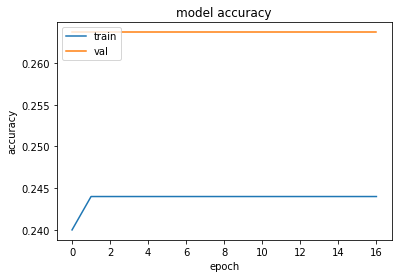

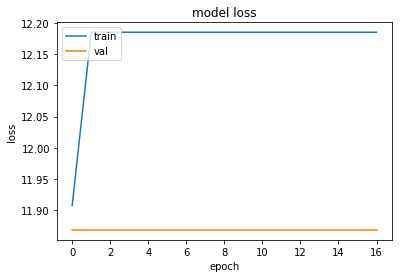

0.26262626262626265
[[ 0 23  0  0]
 [ 0 26  0  0]
 [ 0 27  0  0]
 [ 0 23  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.26      1.00      0.42        26
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        23

    accuracy                           0.26        99
   macro avg       0.07      0.25      0.10        99
weighted avg       0.07      0.26      0.11        99



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


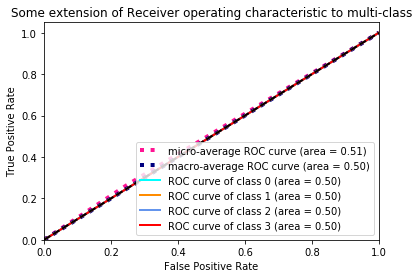

-------------------------End of loop #  0 ---------------------------
-------------------------Start of loop #  1 ---------------------------
End of  fido  loop #  1
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  1
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  1
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  1
(800, 224, 224, 3)
(800,)
fc      200
mm      200
mb      200
fido    200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 12s 23ms/step - lo

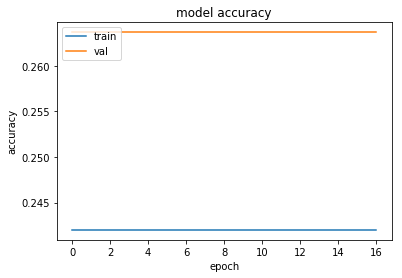

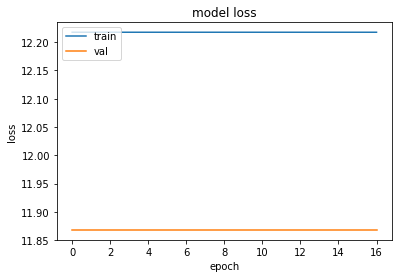

0.26262626262626265
[[ 0 23  0  0]
 [ 0 26  0  0]
 [ 0 27  0  0]
 [ 0 23  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.26      1.00      0.42        26
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        23

    accuracy                           0.26        99
   macro avg       0.07      0.25      0.10        99
weighted avg       0.07      0.26      0.11        99



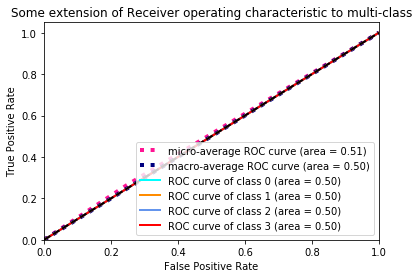

-------------------------End of loop #  1 ---------------------------
-------------------------Start of loop #  2 ---------------------------
End of  fido  loop #  2
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  2
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  2
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  2
(800, 224, 224, 3)
(800,)
fc      200
mm      200
mb      200
fido    200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 13s 26ms/step - lo

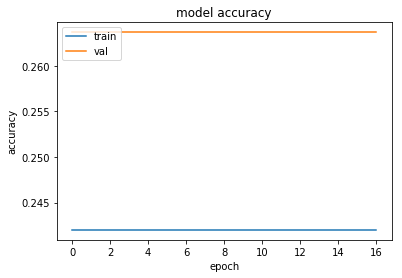

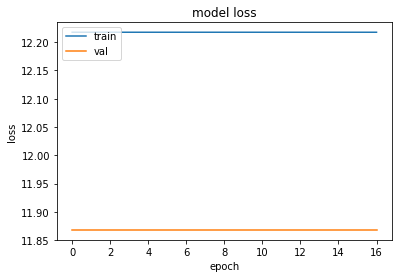

0.26262626262626265
[[ 0 23  0  0]
 [ 0 26  0  0]
 [ 0 27  0  0]
 [ 0 23  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.26      1.00      0.42        26
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        23

    accuracy                           0.26        99
   macro avg       0.07      0.25      0.10        99
weighted avg       0.07      0.26      0.11        99



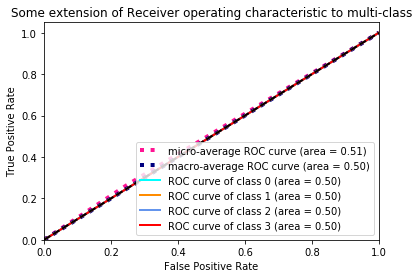

-------------------------End of loop #  2 ---------------------------
-------------------------Start of loop #  3 ---------------------------
End of  fido  loop #  3
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  3
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  3
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  3
(800, 224, 224, 3)
(800,)
fc      200
mm      200
mb      200
fido    200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 15s 29ms/step - lo

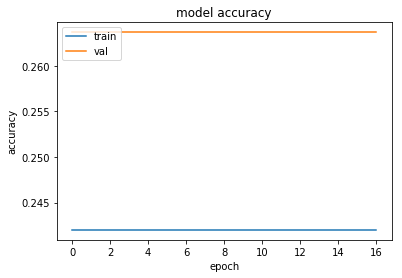

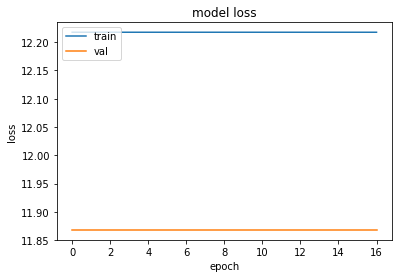

0.26262626262626265
[[ 0 23  0  0]
 [ 0 26  0  0]
 [ 0 27  0  0]
 [ 0 23  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.26      1.00      0.42        26
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        23

    accuracy                           0.26        99
   macro avg       0.07      0.25      0.10        99
weighted avg       0.07      0.26      0.11        99



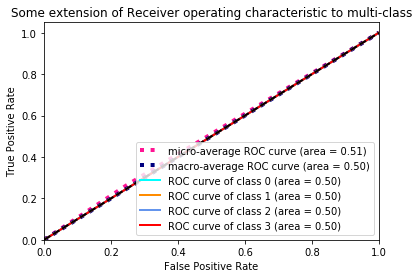

-------------------------End of loop #  3 ---------------------------
-------------------------Start of loop #  4 ---------------------------
End of  mb  loop #  4
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 16s 33ms/step - loss: 12.2175 - acc: 0.2420 - val_loss: 11.8681 - val_acc: 0.2637

Epoch 00001: val_acc improved from -inf to 0.26368, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/resnet/resnet_best_weights.h5
Epoch 2/50
500/500 [=========================

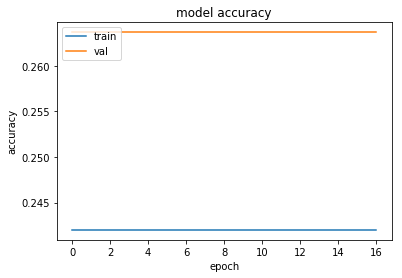

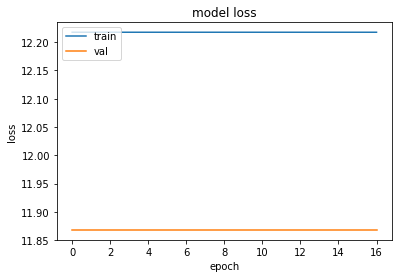

0.26262626262626265
[[ 0 23  0  0]
 [ 0 26  0  0]
 [ 0 27  0  0]
 [ 0 23  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.26      1.00      0.42        26
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        23

    accuracy                           0.26        99
   macro avg       0.07      0.25      0.10        99
weighted avg       0.07      0.26      0.11        99



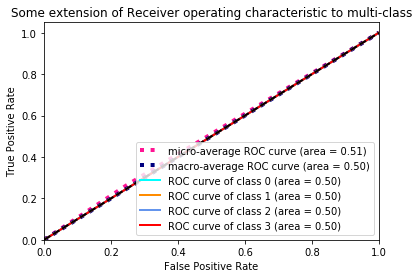

-------------------------End of loop #  4 ---------------------------


In [17]:
trainModelWithNeuralNetworks(intlLoop, ttlLoop, loadBtchSze, modelSaveFolder, modelJsonFile, modelWeighth5, input_shape, imageData, mdl)

In [0]:
intlLoop = 0
ttlLoop = 5
loadBtchSze = 200
modelSaveFolder = '/content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/vgg19/'
modelJsonFile = 'vgg19_model.json'
modelWeighth5 = 'vgg19_best_weights.h5'
input_shape = (224,224,3)
imageData = {'fido':fido_images_path,'mm':mm_images_path,'mb':mb_images_path,'fc':fc_images_path}
mdl ='vgg19' # 'vgg16','vgg19', 'resnet','densenet','mobilenet', 'resnet'

-------------------------Start of loop #  0 ---------------------------
End of  fido  loop #  0
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  0
(400, 224, 224, 3)
(400,)
mm      200
fido    200
dtype: int64
End of  mb  loop #  0
(600, 224, 224, 3)
(600,)
mm      200
fido    200
mb      200
dtype: int64
End of  fc  loop #  0
(800, 224, 224, 3)
(800,)
mb      200
mm      200
fido    200
fc      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
80142336/80134624 [==============================] - 8s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 22s 44ms/step - loss: 4.9733 - acc: 0.5120 - val_loss: 4.5710 - val_acc: 0.6418

Epoch 00001: val_acc improved from -inf to 0.64179, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/vgg19/vgg19_best_weights.h5
Epoch 2/50
500/500 [==============================] - 11s 21ms/step - loss: 4.2725 - acc: 0.6760 - val_loss: 4.3967 - val_acc: 0.6816

Epoch 00002: val_acc improved from 0.64179 to 0.68159, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/vgg19/vgg19_best_weights.h5
Epoch 3/50
500/500 [==============================] - 11s 21ms/step - loss: 4.1384 - acc: 0.6940 - val_loss: 4.5030 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.68159
Epoch 4/50
500/500 [==============================] - 11s 21ms/step - loss: 3.9927 - acc: 0.7380 - val_loss: 4.6298 - val_acc: 0.6468

Epoch 00004: val_acc did not improve from 0.681

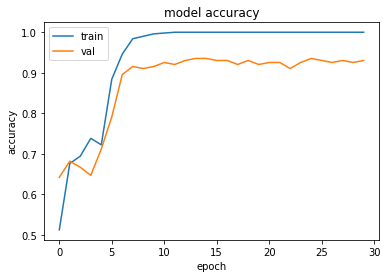

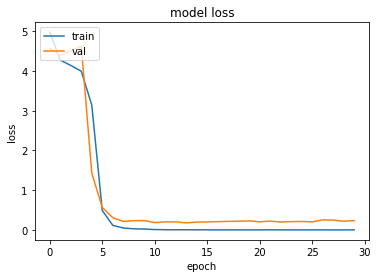

0.9090909090909091
[[20  0  1  2]
 [ 2 24  0  0]
 [ 1  1 25  0]
 [ 1  0  1 21]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.96      0.92      0.94        26
           2       0.93      0.93      0.93        27
           3       0.91      0.91      0.91        23

    accuracy                           0.91        99
   macro avg       0.91      0.91      0.91        99
weighted avg       0.91      0.91      0.91        99



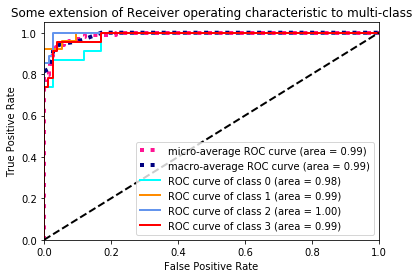

-------------------------End of loop #  0 ---------------------------
-------------------------Start of loop #  1 ---------------------------
End of  fido  loop #  1
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  1
(400, 224, 224, 3)
(400,)
mm      200
fido    200
dtype: int64
End of  mb  loop #  1
(600, 224, 224, 3)
(600,)
mm      200
fido    200
mb      200
dtype: int64
End of  fc  loop #  1
(800, 224, 224, 3)
(800,)
mb      200
mm      200
fido    200
fc      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 20s 40ms/step - lo

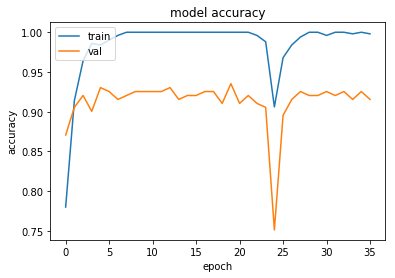

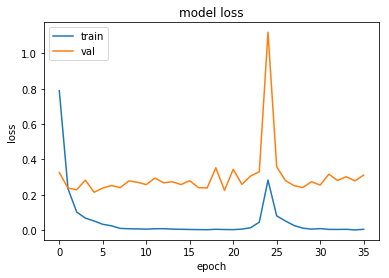

0.898989898989899
[[21  0  1  1]
 [ 1 22  1  2]
 [ 0  2 25  0]
 [ 1  0  1 21]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        23
           1       0.92      0.85      0.88        26
           2       0.89      0.93      0.91        27
           3       0.88      0.91      0.89        23

    accuracy                           0.90        99
   macro avg       0.90      0.90      0.90        99
weighted avg       0.90      0.90      0.90        99



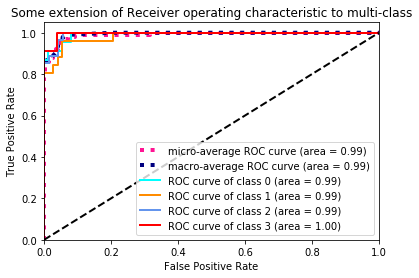

-------------------------End of loop #  1 ---------------------------
-------------------------Start of loop #  2 ---------------------------
End of  fido  loop #  2
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  2
(400, 224, 224, 3)
(400,)
mm      200
fido    200
dtype: int64
End of  mb  loop #  2
(600, 224, 224, 3)
(600,)
mm      200
fido    200
mb      200
dtype: int64
End of  fc  loop #  2
(800, 224, 224, 3)
(800,)
mb      200
mm      200
fido    200
fc      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 20s 40ms/step - lo

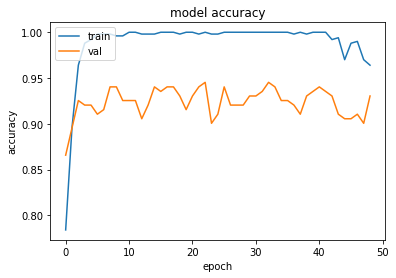

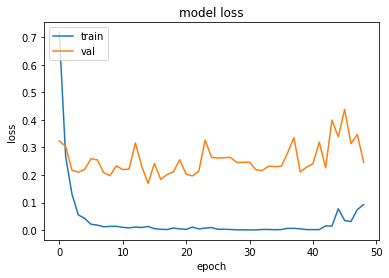

0.9292929292929293
[[21  0  1  1]
 [ 0 26  0  0]
 [ 2  0 25  0]
 [ 3  0  0 20]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        23
           1       1.00      1.00      1.00        26
           2       0.96      0.93      0.94        27
           3       0.95      0.87      0.91        23

    accuracy                           0.93        99
   macro avg       0.93      0.93      0.93        99
weighted avg       0.93      0.93      0.93        99



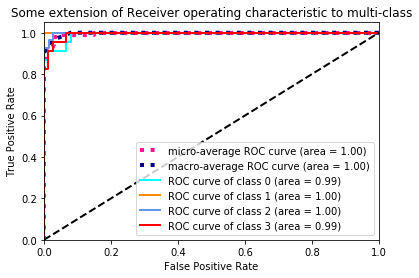

-------------------------End of loop #  2 ---------------------------
-------------------------Start of loop #  3 ---------------------------
End of  fido  loop #  3
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  3
(400, 224, 224, 3)
(400,)
mm      200
fido    200
dtype: int64
End of  mb  loop #  3
(600, 224, 224, 3)
(600,)
mm      200
fido    200
mb      200
dtype: int64
End of  fc  loop #  3
(800, 224, 224, 3)
(800,)
mb      200
mm      200
fido    200
fc      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 20s 41ms/step - lo

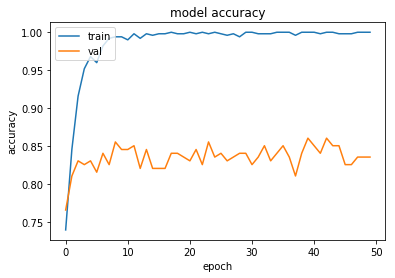

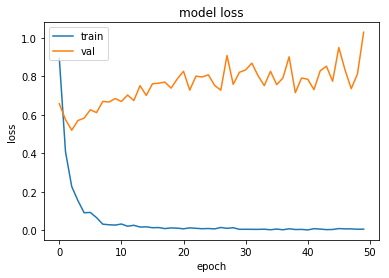

0.8181818181818182
[[20  1  2  0]
 [ 2 24  0  0]
 [ 4  2 21  0]
 [ 4  0  3 16]]
              precision    recall  f1-score   support

           0       0.67      0.87      0.75        23
           1       0.89      0.92      0.91        26
           2       0.81      0.78      0.79        27
           3       1.00      0.70      0.82        23

    accuracy                           0.82        99
   macro avg       0.84      0.82      0.82        99
weighted avg       0.84      0.82      0.82        99



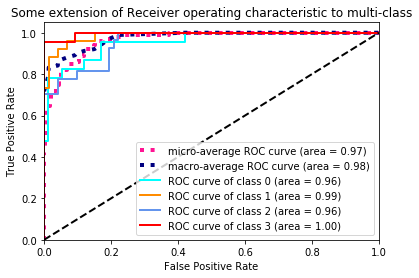

-------------------------End of loop #  3 ---------------------------
-------------------------Start of loop #  4 ---------------------------
End of  mb  loop #  4
(600, 224, 224, 3)
(600,)
mm      200
fido    200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 20s 41ms/step - loss: 0.6825 - acc: 0.8200 - val_loss: 0.2265 - val_acc: 0.9303

Epoch 00001: val_acc improved from -inf to 0.93035, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/vgg19/vgg19_best_weights.h5
Epoch 2/50
500/500 [=============================

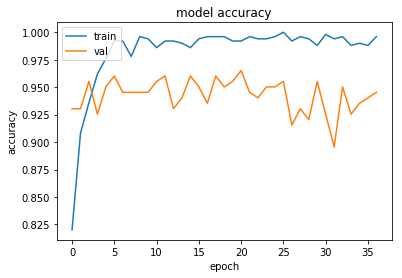

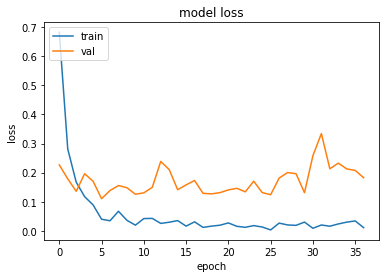

0.9090909090909091
[[22  0  1  0]
 [ 0 22  1  3]
 [ 2  2 23  0]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        23
           1       0.92      0.85      0.88        26
           2       0.92      0.85      0.88        27
           3       0.88      1.00      0.94        23

    accuracy                           0.91        99
   macro avg       0.91      0.91      0.91        99
weighted avg       0.91      0.91      0.91        99



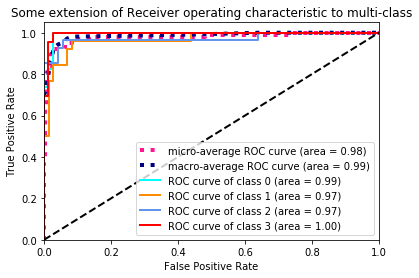

-------------------------End of loop #  4 ---------------------------


In [0]:
trainModelWithNeuralNetworks(intlLoop, ttlLoop, loadBtchSze, modelSaveFolder, modelJsonFile, modelWeighth5, input_shape, imageData, mdl)

In [0]:
intlLoop = 0
ttlLoop = 5
loadBtchSze = 200
modelSaveFolder = '/content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/mobilenet/'
modelJsonFile = 'mobilenet_model.json'
modelWeighth5 = 'mobilenet_best_weights.h5'
input_shape = (224,224,3)
imageData = {'fido':fido_images_path,'mm':mm_images_path,'mb':mb_images_path,'fc':fc_images_path}
mdl ='mobilenet' # 'vgg16','vgg19', 'resnet','densenet','mobilenet'

-------------------------Start of loop #  0 ---------------------------
End of  fido  loop #  0
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  0
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  0
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  0
(800, 224, 224, 3)
(800,)
fido    200
mm      200
fc      200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 8s 17ms/step - loss: 1.1202 - acc: 0.6180 - val_loss: 0.5211 - val_acc: 0.8308

Epoch 00001: val_acc improved from -inf to 0.83085, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/mobilenet/mobilenet_best_weights.h5
Epoch 2/50
500/500 [==============================] - 3s 6ms/step - loss: 0.2355 - acc: 0.9240 - val_loss: 0.3666 - val_acc: 0.8706

Epoch 00002: val_acc improved from 0.83085 to 0.87065, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/mobilenet/mobilenet_best_weights.h5
Epoch 3/50
500/500 [==============================] - 3s 5ms/step - loss: 0.1315 - acc: 0.9500 - val_loss: 0.5888 - val_acc: 0.8259

Epoch 00003: val_acc did not improve from 0.87065
Epoch 4/50
500/500 [==============================] - 3s 5ms/step - loss: 0.3333 - acc: 0.8900 - val_loss: 0.7854 - val_acc: 0.7363

Epoch 00004: val_acc did not improve f

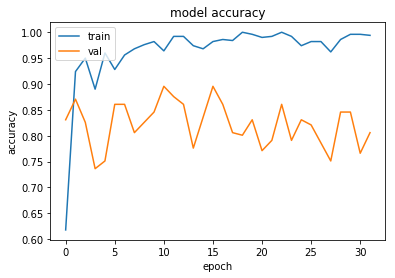

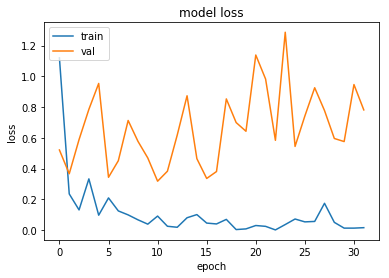

0.8282828282828283
[[12  2  4  5]
 [ 0 20  3  3]
 [ 0  0 27  0]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       1.00      0.52      0.69        23
           1       0.91      0.77      0.83        26
           2       0.79      1.00      0.89        27
           3       0.74      1.00      0.85        23

    accuracy                           0.83        99
   macro avg       0.86      0.82      0.81        99
weighted avg       0.86      0.83      0.82        99



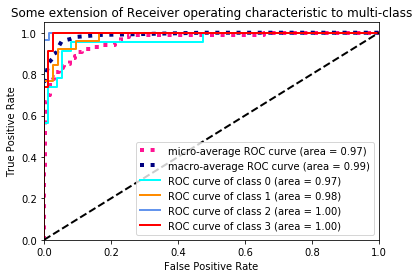

-------------------------End of loop #  0 ---------------------------
-------------------------Start of loop #  1 ---------------------------
End of  fido  loop #  1
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  1
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  1
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  1
(800, 224, 224, 3)
(800,)
fido    200
mm      200
fc      200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 5s 11ms/step - los

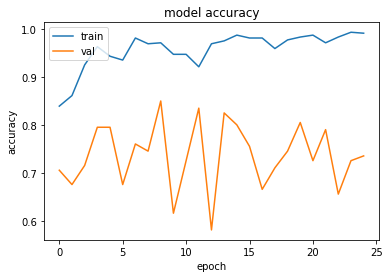

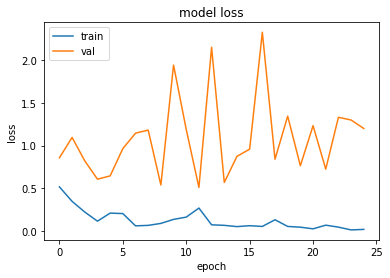

0.7373737373737373
[[16  0  0  7]
 [ 3 11  7  5]
 [ 0  0 26  1]
 [ 1  0  2 20]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74        23
           1       1.00      0.42      0.59        26
           2       0.74      0.96      0.84        27
           3       0.61      0.87      0.71        23

    accuracy                           0.74        99
   macro avg       0.79      0.74      0.72        99
weighted avg       0.79      0.74      0.72        99



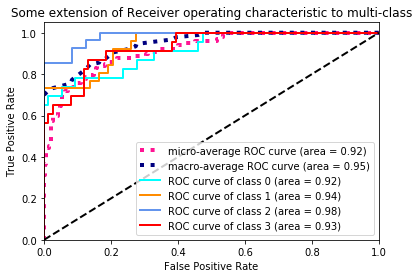

-------------------------End of loop #  1 ---------------------------
-------------------------Start of loop #  2 ---------------------------
End of  fido  loop #  2
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  2
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  2
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  2
(800, 224, 224, 3)
(800,)
fido    200
mm      200
fc      200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 6s 12ms/step - los

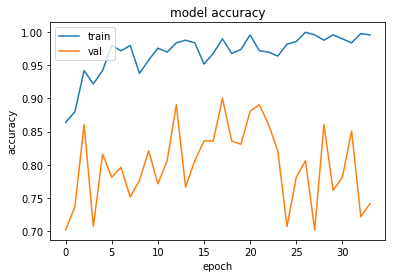

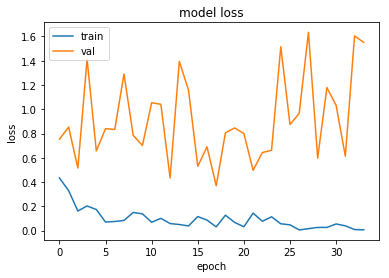

0.7272727272727273
[[10  0 10  3]
 [ 0 15  9  2]
 [ 0  0 26  1]
 [ 0  0  2 21]]
              precision    recall  f1-score   support

           0       1.00      0.43      0.61        23
           1       1.00      0.58      0.73        26
           2       0.55      0.96      0.70        27
           3       0.78      0.91      0.84        23

    accuracy                           0.73        99
   macro avg       0.83      0.72      0.72        99
weighted avg       0.83      0.73      0.72        99



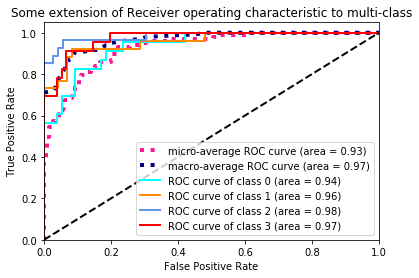

-------------------------End of loop #  2 ---------------------------
-------------------------Start of loop #  3 ---------------------------
End of  fido  loop #  3
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  3
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  3
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  3
(800, 224, 224, 3)
(800,)
fido    200
mm      200
fc      200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 7s 14ms/step - los

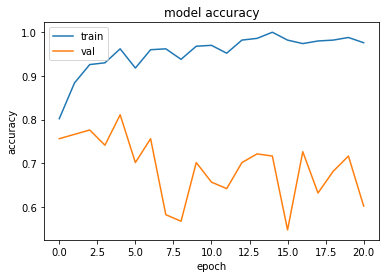

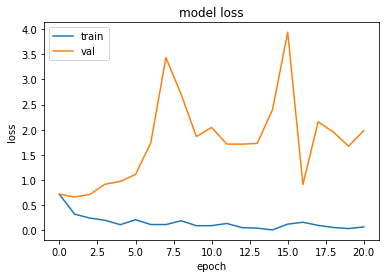

0.6666666666666666
[[ 2  1 11  9]
 [ 0 16 10  0]
 [ 0  0 26  1]
 [ 0  0  1 22]]
              precision    recall  f1-score   support

           0       1.00      0.09      0.16        23
           1       0.94      0.62      0.74        26
           2       0.54      0.96      0.69        27
           3       0.69      0.96      0.80        23

    accuracy                           0.67        99
   macro avg       0.79      0.66      0.60        99
weighted avg       0.79      0.67      0.61        99



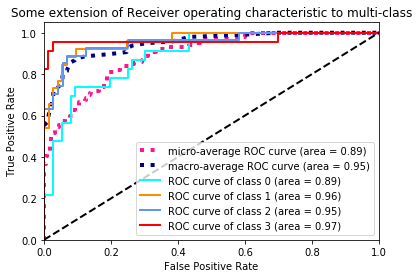

-------------------------End of loop #  3 ---------------------------
-------------------------Start of loop #  4 ---------------------------
End of  mb  loop #  4
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 8s 16ms/step - loss: 0.3757 - acc: 0.8920 - val_loss: 0.9082 - val_acc: 0.7662

Epoch 00001: val_acc improved from -inf to 0.76617, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/mobilenet/mobilenet_best_weights.h5
Epoch 2/50
500/500 [======================

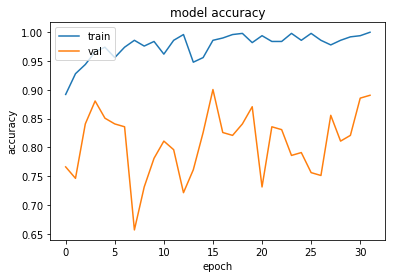

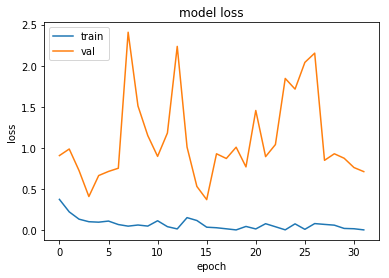

0.8181818181818182
[[14  0  6  3]
 [ 2 17  0  7]
 [ 0  0 27  0]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        23
           1       1.00      0.65      0.79        26
           2       0.82      1.00      0.90        27
           3       0.70      1.00      0.82        23

    accuracy                           0.82        99
   macro avg       0.85      0.82      0.81        99
weighted avg       0.85      0.82      0.81        99



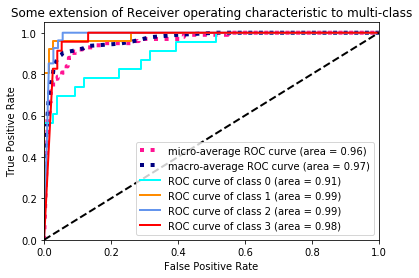

-------------------------End of loop #  4 ---------------------------


In [0]:
trainModelWithNeuralNetworks(intlLoop, ttlLoop, loadBtchSze, modelSaveFolder, modelJsonFile, modelWeighth5, input_shape, imageData, mdl)

In [0]:
intlLoop = 0
ttlLoop = 5
loadBtchSze = 200
modelSaveFolder = '/content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/densenet/'
modelJsonFile = 'densenet_model.json'
modelWeighth5 = 'densenet_best_weights.h5'
input_shape = (224,224,3)
imageData = {'fido':fido_images_path,'mm':mm_images_path,'mb':mb_images_path,'fc':fc_images_path}
mdl ='densenet' # 'vgg16','vgg19', 'resnet','densenet','mobilenet'

-------------------------Start of loop #  0 ---------------------------
End of  fido  loop #  0
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  0
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  0
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  0
(800, 224, 224, 3)
(800,)
fc      200
mm      200
mb      200
fido    200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:166: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 50s 100ms/step - loss: 11.4967 - acc: 0.2620 - val_loss: 12.1086 - val_acc: 0.2488

Epoch 00001: val_acc improved from -inf to 0.24876, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/11Jun2019/densenet/densenet_best_weights.h5
Epoch 2/50
500/500 [==============================] - 12s 25ms/step - loss: 12.0241 - acc: 0.2540 - val_loss: 12.1086 - val_acc: 0.2488

Epoch 00002: val_acc did not improve from 0.24876
Epoch 3/50
500/500 [==============================] - 12s 24ms/step - loss: 12.0241 - acc: 0.2540 - val_loss: 12.1086 - val_acc: 0.2488

Epoch 00003: val_acc did not improve from 0.24876
Epoch 4/50
500/500 [==============================] - 12s 24ms/step - loss: 12.0241 - acc: 0.2540 - val_loss: 12.1086 - val_acc: 0.2488

Epoch 00004: val_acc did not improve from 0.24876
Epoch 5/50
500/500 [==============================] - 12s 24ms/step - loss: 12.0241 - acc: 0

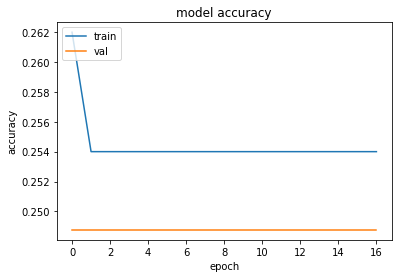

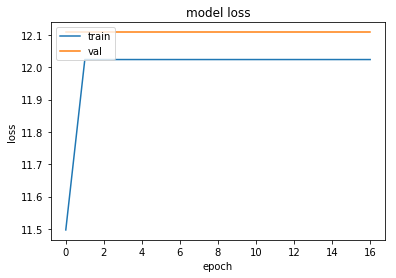

0.23232323232323232
[[ 0  0  0 23]
 [ 0  0  0 26]
 [ 0  0  0 27]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00        27
           3       0.23      1.00      0.38        23

    accuracy                           0.23        99
   macro avg       0.06      0.25      0.09        99
weighted avg       0.05      0.23      0.09        99



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


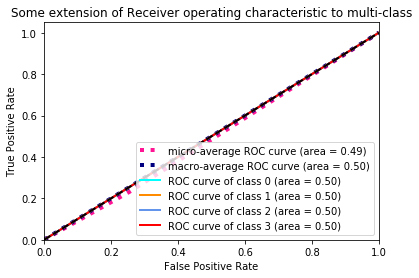

-------------------------End of loop #  0 ---------------------------
-------------------------Start of loop #  1 ---------------------------
End of  fido  loop #  1
(200, 224, 224, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  1
(400, 224, 224, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  1
(600, 224, 224, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  1
(800, 224, 224, 3)
(800,)
fc      200
mm      200
mb      200
fido    200
dtype: int64
X_test and Y_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 224, 224, 3)
(201, 224, 224, 3)
(99, 224, 224, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64


In [0]:
trainModelWithNeuralNetworks(intlLoop, ttlLoop, loadBtchSze, modelSaveFolder, modelJsonFile, modelWeighth5, input_shape, imageData, mdl)

In [0]:
createFolder('/content/gdrive/My Drive/Capstone/Characters/Model/12Jun2019/')

In [0]:
intlLoop = 0
ttlLoop = 5
loadBtchSze = 200
modelSaveFolder = '/content/gdrive/My Drive/Capstone/Characters/Model/12Jun2019/inceptionv3/'
modelJsonFile = 'incv3_model.json'
modelWeighth5 = 'incv3_best_weights.h5'
input_shape = (299,299,3)
resize_shape = (299,299)
imageData = {'fido':fido_images_path,'mm':mm_images_path,'mb':mb_images_path,'fc':fc_images_path}
mdl ='inceptionv3' # 'vgg16','vgg19', 'resnet','densenet','mobilenet'

-------------------------Start of loop #  0 ---------------------------
End of  fido  loop #  0
(200, 299, 299, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  0
(400, 299, 299, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  0
(600, 299, 299, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  0
(800, 299, 299, 3)
(800,)
fido    200
fc      200
mm      200
mb      200
dtype: int64
X_test and Y_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:207: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 45s 90ms/step - loss: 1.3534 - acc: 0.6000 - val_loss: 1.3855 - val_acc: 0.2338

Epoch 00001: val_acc improved from -inf to 0.23383, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/12Jun2019/inceptionv3/incv3_best_weights.h5
Epoch 2/50
500/500 [==============================] - 23s 46ms/step - loss: 1.3331 - acc: 0.6340 - val_loss: 1.3856 - val_acc: 0.2637

Epoch 00002: val_acc improved from 0.23383 to 0.26368, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/12Jun2019/inceptionv3/incv3_best_weights.h5
Epoch 3/50
500/500 [==============================] - 23s 46ms/step - loss: 1.3218 - acc: 0.5940 - val_loss: 1.3883 - val_acc: 0.2289

Epoch 00003: val_acc did not improve from 0.26368
Epoch 4/50
500/500 [==============================] - 23s 46ms/step - loss: 1.3157 - acc: 0.5960 - val_loss: 1.3855 - val_acc: 0.2537

Epoch 00004: val_acc did not improv

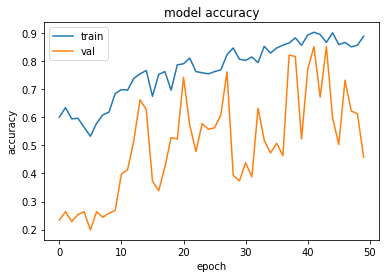

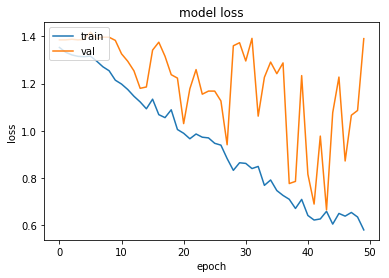

0.45454545454545453
[[ 4  0 17  2]
 [ 0  7 18  1]
 [ 0  0 27  0]
 [ 0  0 16  7]]
              precision    recall  f1-score   support

           0       1.00      0.17      0.30        23
           1       1.00      0.27      0.42        26
           2       0.35      1.00      0.51        27
           3       0.70      0.30      0.42        23

    accuracy                           0.45        99
   macro avg       0.76      0.44      0.41        99
weighted avg       0.75      0.45      0.42        99



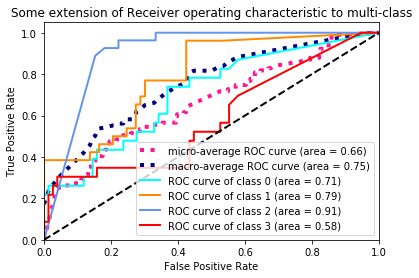

-------------------------End of loop #  0 ---------------------------
-------------------------Start of loop #  1 ---------------------------
End of  fido  loop #  1
(200, 299, 299, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  1
(400, 299, 299, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  1
(600, 299, 299, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  1
(800, 299, 299, 3)
(800,)
fido    200
fc      200
mm      200
mb      200
dtype: int64
X_test and Y_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 42s 83ms/step - lo

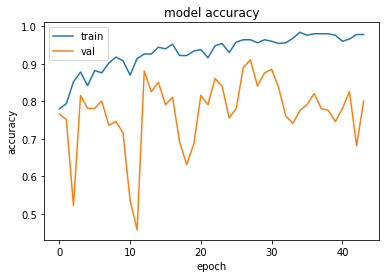

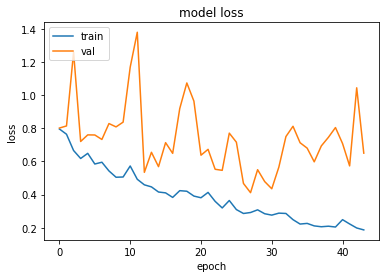

0.797979797979798
[[20  0  1  2]
 [ 1 13  3  9]
 [ 0  0 23  4]
 [ 0  0  0 23]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        23
           1       1.00      0.50      0.67        26
           2       0.85      0.85      0.85        27
           3       0.61      1.00      0.75        23

    accuracy                           0.80        99
   macro avg       0.85      0.81      0.80        99
weighted avg       0.86      0.80      0.79        99



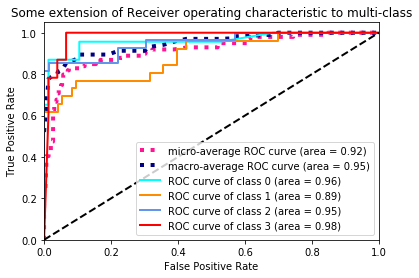

-------------------------End of loop #  1 ---------------------------
-------------------------Start of loop #  2 ---------------------------
End of  fido  loop #  2
(200, 299, 299, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  2
(400, 299, 299, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  2
(600, 299, 299, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  2
(800, 299, 299, 3)
(800,)
fido    200
fc      200
mm      200
mb      200
dtype: int64
X_test and Y_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 46s 93ms/step - lo

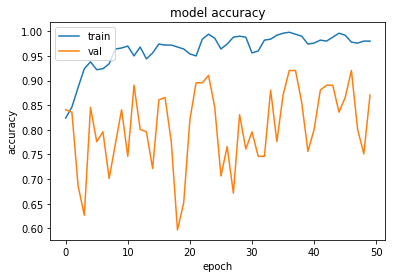

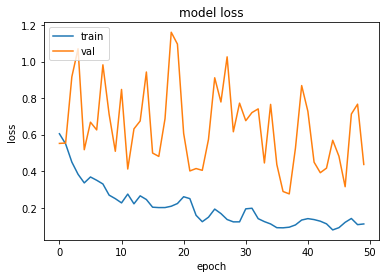

0.8787878787878788
[[19  2  2  0]
 [ 0 26  0  0]
 [ 0  2 25  0]
 [ 2  3  1 17]]
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        23
           1       0.79      1.00      0.88        26
           2       0.89      0.93      0.91        27
           3       1.00      0.74      0.85        23

    accuracy                           0.88        99
   macro avg       0.90      0.87      0.88        99
weighted avg       0.89      0.88      0.88        99



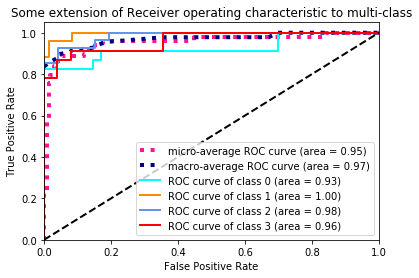

-------------------------End of loop #  2 ---------------------------
-------------------------Start of loop #  3 ---------------------------
End of  fido  loop #  3
(200, 299, 299, 3)
(200,)
fido    200
dtype: int64
End of  mm  loop #  3
(400, 299, 299, 3)
(400,)
fido    200
mm      200
dtype: int64
End of  mb  loop #  3
(600, 299, 299, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
End of  fc  loop #  3
(800, 299, 299, 3)
(800,)
fido    200
fc      200
mm      200
mb      200
dtype: int64
X_test and Y_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 52s 104ms/step - l

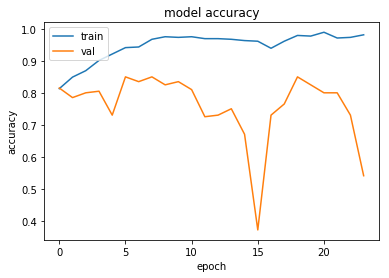

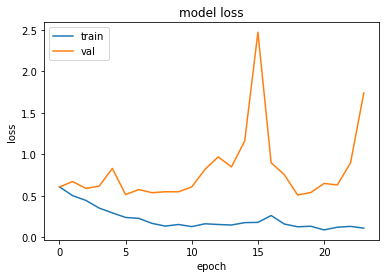

0.48484848484848486
[[ 5 17  0  1]
 [ 0 26  0  0]
 [ 1 22  3  1]
 [ 1  8  0 14]]
              precision    recall  f1-score   support

           0       0.71      0.22      0.33        23
           1       0.36      1.00      0.53        26
           2       1.00      0.11      0.20        27
           3       0.88      0.61      0.72        23

    accuracy                           0.48        99
   macro avg       0.74      0.48      0.44        99
weighted avg       0.74      0.48      0.44        99



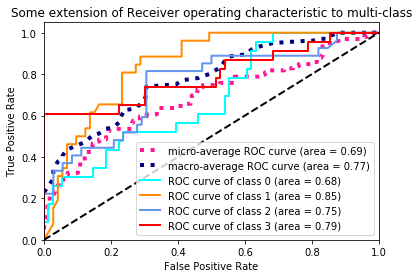

-------------------------End of loop #  3 ---------------------------
-------------------------Start of loop #  4 ---------------------------
End of  mb  loop #  4
(600, 299, 299, 3)
(600,)
fido    200
mm      200
mb      200
dtype: int64
X_test and Y_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500, 4)
(201, 4)
(99, 4)
X_a_test and Y_a_test split
(500, 299, 299, 3)
(201, 299, 299, 3)
(99, 299, 299, 3)
(500,)
(201,)
(99,)
Y_a_test classwise count
3    127
2    127
0    125
1    121
dtype: int64
1    53
0    52
3    50
2    46
dtype: int64
2    27
1    26
3    23
0    23
dtype: int64
Train on 500 samples, validate on 201 samples
Epoch 1/50
500/500 [==============================] - 59s 117ms/step - loss: 0.5054 - acc: 0.8440 - val_loss: 0.5531 - val_acc: 0.8209

Epoch 00001: val_acc improved from -inf to 0.82090, saving model to /content/gdrive/My Drive/Capstone/Characters/Model/12Jun2019/inceptionv3/incv3_best_weights.h5
Epoch 2/50
500/500 [======================

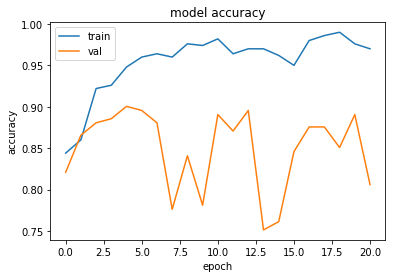

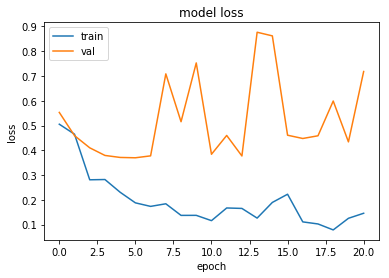

0.7171717171717171
[[22  0  0  1]
 [ 9 16  1  0]
 [ 7  3 16  1]
 [ 5  1  0 17]]
              precision    recall  f1-score   support

           0       0.51      0.96      0.67        23
           1       0.80      0.62      0.70        26
           2       0.94      0.59      0.73        27
           3       0.89      0.74      0.81        23

    accuracy                           0.72        99
   macro avg       0.79      0.73      0.72        99
weighted avg       0.79      0.72      0.72        99



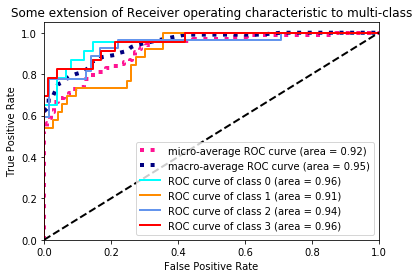

-------------------------End of loop #  4 ---------------------------


In [17]:
trainModelWithNeuralNetworks(intlLoop, ttlLoop, loadBtchSze, modelSaveFolder, modelJsonFile, modelWeighth5, resize_shape, input_shape, imageData, mdl)